In [1]:
import matplotlib.pyplot as plt
import random
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA

In [2]:
#load data
DroneData = pd.read_csv('./DroneData/SP Cup 2020/IMU_camera Drone Synchronized training dataset_normal behabiour_no abnormalities/_slash_mavros_slash_imu_slash_data.csv')

In [3]:
def extract_normalization_params(DroneData, params = ['x','y','z','x.1','y.1','z.1','x.2','y.2','z.2']):
    """
    Extracts only the normal distribution z scores 
    of from the data
    input = Data, parameters
    """
    imuParamsData = DroneData.loc[:, params]
    normImuData = (imuParamsData - imuParamsData.mean())/imuParamsData.std()
    return normImuData, imuParamsData.mean(), imuParamsData.std()

def normalize_test_data(Data, mean, std, params = ['x','y','z','x.1','y.1','z.1','x.2','y.2','z.2']):
    imuParamsData = Data.loc[:, params]
    normImuData = (imuParamsData - mean)/std
    return normImuData

def find_theta_score(Data,dims=1):
    """
    Converts n dimensions to a lower dimensional score,
    for easier visualization
    """
    pca = PCA(n_components=dims)
    pca.fit(Data)
    theta_score = pca.transform(Data)
    return theta_score

def plot_anomalies_in_1D(z_score, anomalyPrediction):
    """
    plots anomalies (red) and 1D z score of the dataset
    """
    plt.figure(figsize=(12,7))
    for i in range(len(z_score)):
        if anomalyPrediction[i] == True:
            plt.scatter(i,z_score[i],c = 'r')
    plt.plot(z_score)

def plot_anomalies_in_2D(z2_score, anomalyPrediction):
    """
    plots z1 and z2 as a scatter plot on x and y axes respectively,
    with anomalies as red points and normal instances as blue
    """
    plt.figure(2)
    plt.figure(figsize=(12,7))
    for i in range(len(z2_score.T)):
        if anomalyPrediction[i]:
            plt.scatter(z2_score[0][i],z2_score[1][i],c = 'r')
        else:
            plt.scatter(z2_score[0][i],z2_score[1][i],c = 'b')
            
def generate_metrics(anomalyPrediction,testDataLabel):
    """
    generates accuracy and detection rate metrics, takes
    into input the prediction and the label column of the data
    lengths of the two vectors must match
    """
    actual_value = testDataLabel == 4
    #how many readings match
    N_set = anomalyPrediction == actual_value
    
    accuracy = sum(N_set)/len(testDataLabel)
    detection_rate = sum(anomalyPrediction)/sum(actual_value)
    false_positives = sum(np.logical_and((np.invert(actual_value)), anomalyPrediction))/len(testDataLabel)
    false_negatives = sum(np.logical_and(actual_value, np.invert(anomalyPrediction)))/len(testDataLabel)
    print('accuracy = ', accuracy,',detection rate =', detection_rate,'\nfalse positive rate = '
          ,false_positives,',false negative rate =',false_negatives)


In [4]:
#fit mean and std for normalization

normImuData, mean , std = extract_normalization_params(DroneData)
trainData = normImuData

In [5]:
#import new test data here
testData1 = normalize_test_data(pd.concat([pd.read_csv('DroneData/SP Cup 2020/03_Dataset with 5 normal experiments_17Jan2020/2020-01-17-11-32-12/_slash_mavros_slash_imu_slash_data.csv'),
                                         pd.read_csv('DroneData/SP Cup 2020/03_Dataset with 5 normal experiments_17Jan2020/2020-01-17-11-32-49/_slash_mavros_slash_imu_slash_data.csv'),
                                          pd.read_csv('DroneData/SP Cup 2020/03_Dataset with 5 normal experiments_17Jan2020/2020-01-17-11-33-26/_slash_mavros_slash_imu_slash_data.csv'),
                                          pd.read_csv('DroneData/SP Cup 2020/03_Dataset with 5 normal experiments_17Jan2020/2020-01-17-11-34-08/_slash_mavros_slash_imu_slash_data.csv'),
                                          pd.read_csv('DroneData/SP Cup 2020/03_Dataset with 5 normal experiments_17Jan2020/2020-01-17-11-34-43/_slash_mavros_slash_imu_slash_data.csv')]), mean, std)

testData2 = normalize_test_data(pd.read_csv('DroneData/SP Cup 2020/04_Dataset with 5 abnormal experiments_17Jan2020/2020-01-17-11-37-25/_slash_mavros_slash_imu_slash_data.csv'), mean, std)

z_score1 = find_theta_score(testData1, 2)
z_score2 = find_theta_score(testData2, 2)

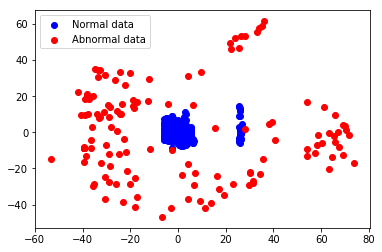

In [6]:
plt.scatter(z_score1[:, 0], z_score1[:, 1], color='b')
plt.scatter(z_score2[:, 0], z_score2[:, 1], color='r')

plt.legend(['Normal data', 'Abnormal data'])
plt.show()

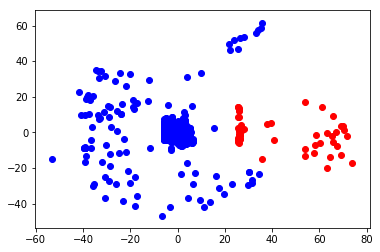

In [7]:
from sklearn import cluster

z = np.concatenate([z_score1, z_score2])
spectral = cluster.SpectralClustering(n_clusters=2, eigen_solver='arpack', affinity='nearest_neighbors')
spectral.fit(z)

colors = ['r', 'b']
y_pred = spectral.labels_.astype(np.int)

for i, x in enumerate(z):
  c = 'r' if y_pred[i] else 'b'
  plt.scatter(x[0], x[1], color=c)
  
plt.show()

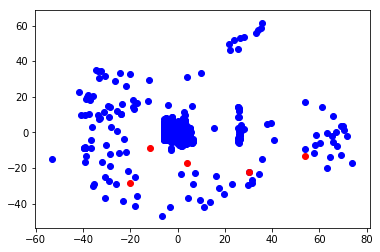

In [8]:
average_linkage = cluster.AgglomerativeClustering(linkage="average", affinity="cityblock", n_clusters=2)
average_linkage.fit(np.concatenate([testData1, testData2]))
average_linkage.labels_


colors = ['r', 'b']
y_pred = average_linkage.labels_.astype(np.int)

for i, x in enumerate(z):
  c = 'r' if y_pred[i] else 'b'
  plt.scatter(x[0], x[1], color=c)
  
plt.show()

In [9]:
len(z_score2)

136

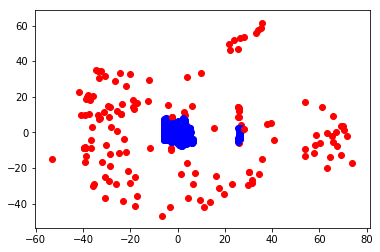

In [23]:
from pyod.models.knn import KNN

clf = KNN()
clf.fit(z_score1)

scores = clf.decision_scores_
test_scores = clf.decision_function(z_score2)

thres = scores.mean()+3*scores.std()

colors = ['r', 'b']
y_pred = average_linkage.labels_.astype(np.int)

for i, x in enumerate(z_score1):
  c = 'r' if scores[i] > thres else 'b'
  plt.scatter(x[0], x[1], color=c)
  
for i, x in enumerate(z_score2):
  c = 'r' if test_scores[i] > thres else 'b'
  plt.scatter(x[0], x[1], color=c)
  
plt.show()

In [24]:
scores

array([ 0.61969319,  0.2954852 ,  0.41367858,  0.34352692,  0.49142271,
        0.40788164,  0.29509382,  0.22016131,  0.28857549,  4.26982771,
        3.13579221,  0.83839784,  1.3246117 ,  0.97586228,  0.57481291,
        0.88211449,  0.33402193,  1.11912757,  1.59405978,  1.27346432,
        1.05862863,  0.42728026,  0.37062649,  0.396667  ,  0.47106465,
        0.55766042,  0.55316509,  0.99168838,  1.42928973,  1.46395191,
        1.11113892,  0.59862859,  0.4298496 ,  0.4537931 ,  0.46052029,
        0.50384646,  0.51967602,  0.35967339,  0.35667566,  0.48574741,
        0.70505075,  0.83584517,  0.69130804,  0.51236172,  0.41741408,
        0.33444845,  0.43951685,  0.43951685,  0.53557951,  0.63539559,
        0.49762097,  0.45768591,  0.49200368,  0.4526342 ,  0.38993016,
        0.77805516,  0.64940293,  0.47868527,  1.11448004,  1.24673281,
        1.39934063,  1.44617511,  1.66471363,  1.84525526,  1.48700498,
        1.35576686,  1.2977789 ,  0.71241997,  0.75998039,  0.70